## Neuron Simulations

Neurons have complex biophysical properties that can be simulated using python.
In the following I will present progressively more complex models of neuron simulation.
The project will be concluded by an algorithm that translates auditory information into electrical signals that activate neurons in the cochlea (inner ear). Its a rudimentary approach to a cochela implant algorithm

## The Leaky Integrate and Fire Model

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


def membrane_voltage(vm, i_stim, cm, g_leak, params):
    r = 1 / g_leak
    tau = cm * r

    for index in range(len(params["time"]) - 1):
        if vm[index] < params["v_thr"]:
            vm[index + 1] = (((-vm[index] + params["v_rest"]) / tau) + (i_stim[index] / cm)) * \
                            params["step_size"] + vm[index]
        elif vm[index] == params["v_spike"]:
            vm[index + 1] = params["v_rest"]
        elif vm[index] > params["v_thr"]:
            vm[index + 1] = params["v_spike"]

    return vm


# Define the params dictionary
params = {
    "v_rest": -70e-3,
    "v_thr": -30e-3,
    "v_spike": 20e-3,
    "step_size": 30e-6,
    "cm": 1e-6,
}

params["time"] = np.arange(0, 0.1, params["step_size"])

# Create an interactive plot using widgets.interact
i_stim_slider = widgets.FloatSlider(
    value=10e-6,
    min=3, 
    max=10, 
    step=2, 
    description='I_stim [uA]',
    continuous_update=False
)

def interactive_plot(i_stim_val):
    vm = np.zeros(len(params["time"]))
    vm[0] = params["v_rest"]

    i_stim = np.zeros(len(params["time"]))
    i_stim[:4999] = i_stim_val/1_000_000 # Stimulation current in uA

    g_leak = 100e-6

    vm = membrane_voltage(vm, i_stim, params["cm"], g_leak, params)

    plt.figure(figsize=(16, 6))
    plt.plot(params["time"], vm)
    plt.axhline(y=-0.03, linestyle="dashed", color="red", label='Threshhold potential (-30mV)')
    plt.xlabel("Time (s)")
    plt.ylabel("Membrane Voltage (V)")
    plt.title("Leaky Integrated Fire Model")
    plt.grid()
    plt.legend()

    plt.show()

widgets.interactive(interactive_plot, i_stim_val=i_stim_slider)

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='I_stim [uA]', max=10.0, min…

## Hodgkin-Huxley-Model

LIF models are relatively easy to understand and provide clear explanations for simple neuronal
processes. However, they also quickly reach their limits when simulating more complex behaviour. For
more complicated problems, models are used that better describe the intricate biophysical reality of
neurons. The first model of this kind was published by Hodgkin and Huxley in 1952. Their work on the
giant squid axon enabled the authors to develop a set of equations to describe the biophysical
properties of the axon. The equations contain information about the current of the two most
important cations: Sodium and potassium. And in addition, a third undetermined leakage current.
As already stated above, the transmembrane current for an ion species can be described with the
open probability of the corresponding channels. Hodgkin and Huxley have used a similar formulation
for their model. They used the maximum conductivity ĝ to describe the transmembrane currents of
a particular ion species, this is achieved when all channels for an ion species are opened
simultaneously. In this case the opening probabilities can be described as a product of ĝ with one or
more gating variables. This modulates the effective conductance of these channels between none
and maximum conductivity. This idea can also be visualized with an equivalent circuit, in which the
channels are implemented by voltage-dependent resistors that selectively regulate the current
through the individual channel.

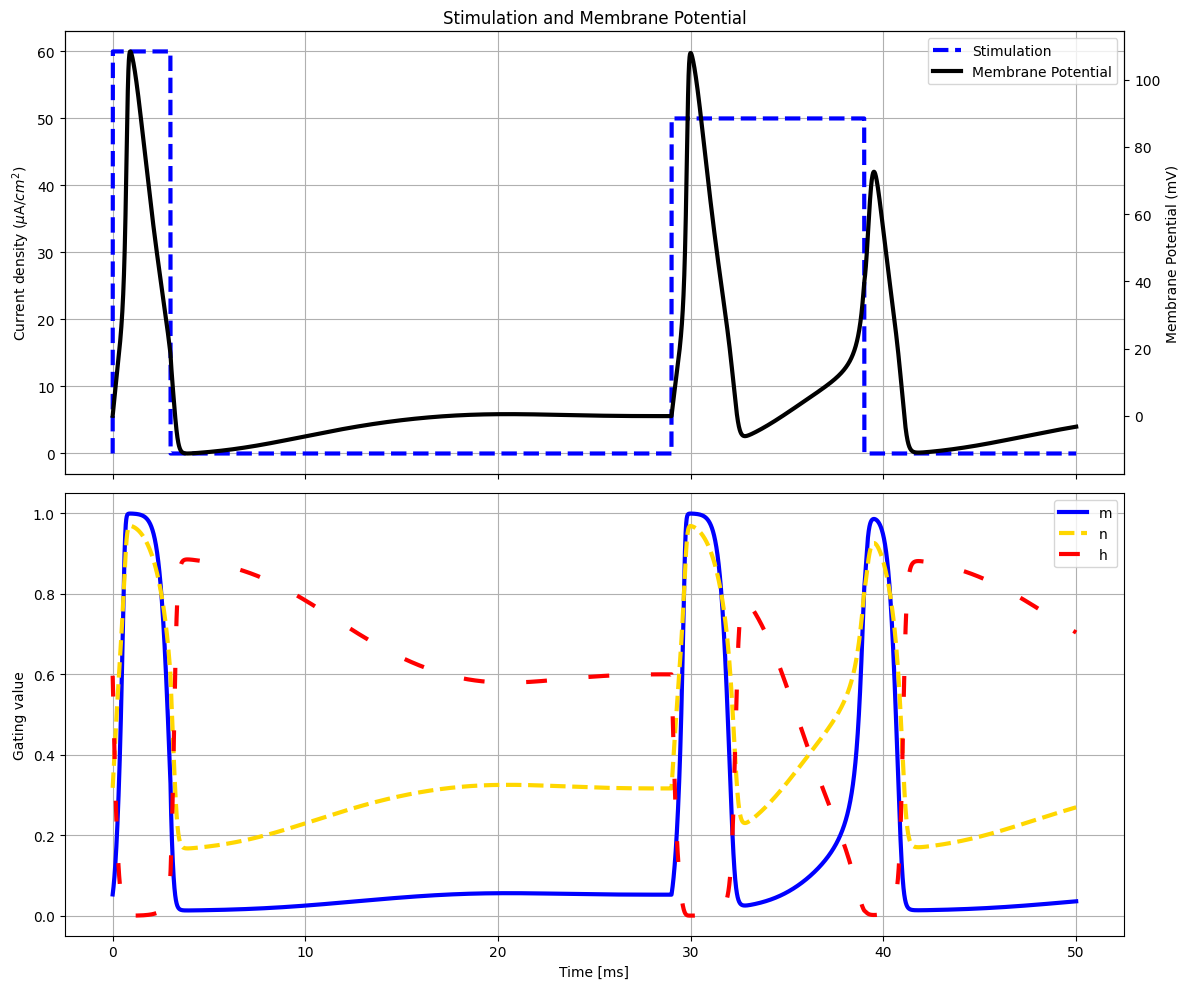

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Constants
np.random.seed(1000)
tmin = 0.0
tmax = 50.0
gK = 36.0  # Potassium conductivity [ms/cm2]
gNa = 120.0  # Sodium conductivity [ms/cm2]
gL = 0.3  # Leak conductivity [ms/cm2]
Cm = 1.0  # Membrane potential [uF/cm2]
VK = -12.0  # Nernst Potential Potassium [mV]
VNa = 115.0  # Nernst Potential Sodium [mV]
Vl = 10.6  # Leakage potential [mV]
T = np.linspace(tmin, tmax, 10000)


# Ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)


def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)


def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)


def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)


def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


# Steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))


def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))


def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))


# Input stimulus
def Id(t):
    if 0.0 < t < 3.0:
        return 60.0
    elif 29.0 < t < 39.0:
        return 50.0
    return 0.0


# Compute derivatives
def compute_derivatives(y, t0):
    Vm, n, m, h = y

    GK = (gK / Cm) * n ** 4.0
    GNa = (gNa / Cm) * m ** 3.0 * h
    GL = gL / Cm

    dy = [
        (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl)),
        alpha_n(Vm) * (1.0 - n) - beta_n(Vm) * n,
        alpha_m(Vm) * (1.0 - m) - beta_m(Vm) * m,
        alpha_h(Vm) * (1.0 - h) - beta_h(Vm) * h
    ]
    return dy


# Initial conditions
Y0 = [0.0, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

# Input stimulus
Idv = np.vectorize(Id)(T)

# Plotting
fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# First subplot: Stimulation and Membrane Potential
axes1.plot(T, Idv, linestyle="dashed", color="blue", label='Stimulation', linewidth=3)
axes1.set_ylabel(r'Current density ($\mu$A/$cm^2$)')
axes1.set_title('Stimulation and Membrane Potential')
axes1.grid()

axes1_2 = axes1.twinx()  # Twin axes for membrane potential
axes1_2.plot(T, Vy[:, 0], color='black', label='Membrane Potential', linewidth=3)
axes1_2.set_ylabel('Membrane Potential (mV)')

# Combine the legends from the first subplot
lines1, labels1 = axes1.get_legend_handles_labels()
lines1_2, labels1_2 = axes1_2.get_legend_handles_labels()
axes1_2.legend(lines1 + lines1_2, labels1 + labels1_2, loc='upper right')

# Second subplot: Membrane Potential and Gating Variable "m"
axes2.plot(T, m_inf(Vy[:, 0]), color="blue", linewidth=3, label="m")
axes2.plot(T, n_inf(Vy[:, 0]), color="gold", linewidth=3, label="n", linestyle="dashed")
axes2.plot(T, h_inf(Vy[:, 0]), color="red", linewidth=3, label="h",  linestyle=(0,(5, 10)))
axes2.set_xlabel('Time [ms]')
axes2.set_ylabel('Gating value')
axes2.grid()
axes2.legend()

plt.tight_layout()
plt.show()

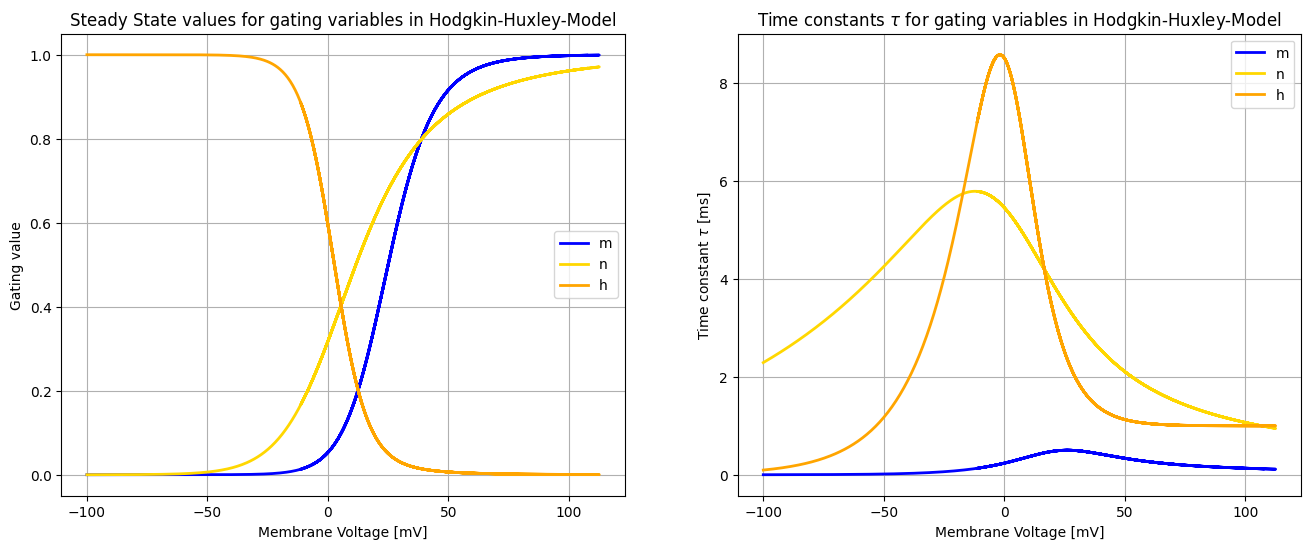

In [59]:
# Initial conditions
Y0 = [-100, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

fig, ax = plt.subplots(1,2, figsize=(16, 6))
Vm_values = Vy[:, 0]

ax[0].plot(Vm_values, m_inf(Vm_values), color="blue", linewidth=2, label="m")
ax[0].plot(Vm_values, n_inf(Vy[:, 0]), color="gold", linewidth=2, label="n")
ax[0].plot(Vy[:, 0], h_inf(Vy[:, 0]), color="orange", linewidth=2, label="h")
ax[0].set_xlabel("Membrane Voltage [mV]")
ax[0].set_ylabel("Gating value")
ax[0].set_title("Steady State values for gating variables in Hodgkin-Huxley-Model")
ax[0].legend()
ax[0].grid()


m_time_const = (1/(alpha_m(Vm_values)+beta_m(Vm_values)))
n_time_const = (1/(alpha_n(Vm_values)+beta_n(Vm_values)))
h_time_const = (1/(alpha_h(Vm_values)+beta_h(Vm_values)))

ax[1].plot(Vm_values, m_time_const, color="blue", linewidth=2, label="m")
ax[1].plot(Vm_values, n_time_const, color="gold", linewidth=2, label="n")
ax[1].plot(Vm_values, h_time_const, color="orange", linewidth=2, label="h")

ax[1].set_xlabel("Membrane Voltage [mV]")
ax[1].set_ylabel(r"Time constant $\tau$ [ms]")
ax[1].set_title(r"Time constants $\tau$ for gating variables in Hodgkin-Huxley-Model")
ax[1].legend()
ax[1].grid()


plt.show()


## Passive Cable Neuron Model

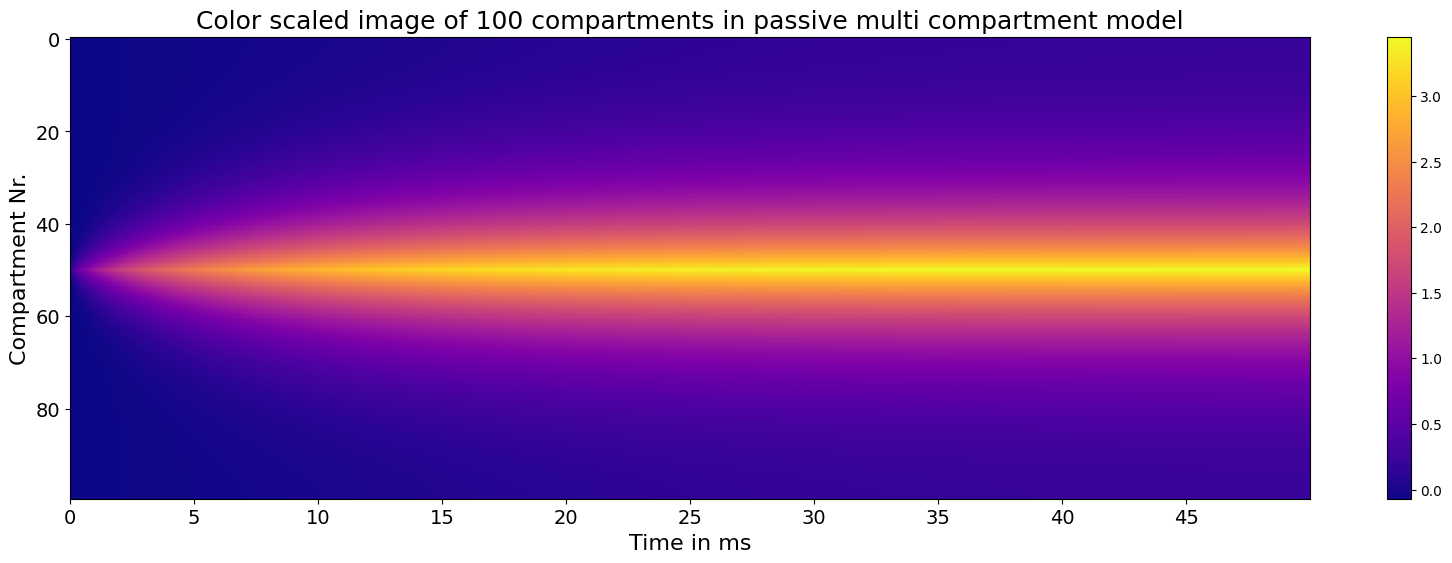

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
# time
dt = 0.01
t = np.arange(dt, 50 + dt, dt)

# compartments
n = 100

# membrane
Cm = 1
Rm = 10

# membrane voltage
Vm = np.ones((n, len(t)))*-70e-3

# axon
p = 6e-4
L = 0.1e-4
r = 2e-4
Ra = (p * L) / (np.pi * r ** 2)

c = np.ones(n) * -2
c[0] = -1
c[-1] = -1

C = np.diag(c) + np.diag(np.ones(n - 1), 1) + np.diag(np.ones(n - 1), -1)

A = np.eye(n) - (dt / (Cm * Ra)) * C

Istim = np.zeros((n, len(t)))
Istim[n // 2, :] = 10

for idx in range(len(t) - 1):
    Ihh = Vm[:, idx] / Rm
    b = Vm[:, idx] + (dt / Cm * (-Ihh + Istim[:, idx])).astype(np.float64) # np.float64 prevents RuntimeWarning: overflow encountered in scalar operation
    Vm[:, idx + 1] = np.linalg.solve(A, b)

lambda_val = np.max(Vm[49, :]) * 0.37

# Plots
fig, ax = plt.subplots(figsize=(20, 6))

# Color scaled image of compartments
im = ax.imshow(Vm, aspect='auto', cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('Time in ms', fontsize=16)
ax.set_ylabel('Compartment Nr.', fontsize=16)
ax.set_title('Color scaled image of 100 compartments in passive multi compartment model', fontsize=18)
ax.set_xticks(np.arange(0, len(t), len(t) // 10))
ax.set_xticklabels(np.arange(0, 50, 5))
ax.tick_params(labelsize=14)

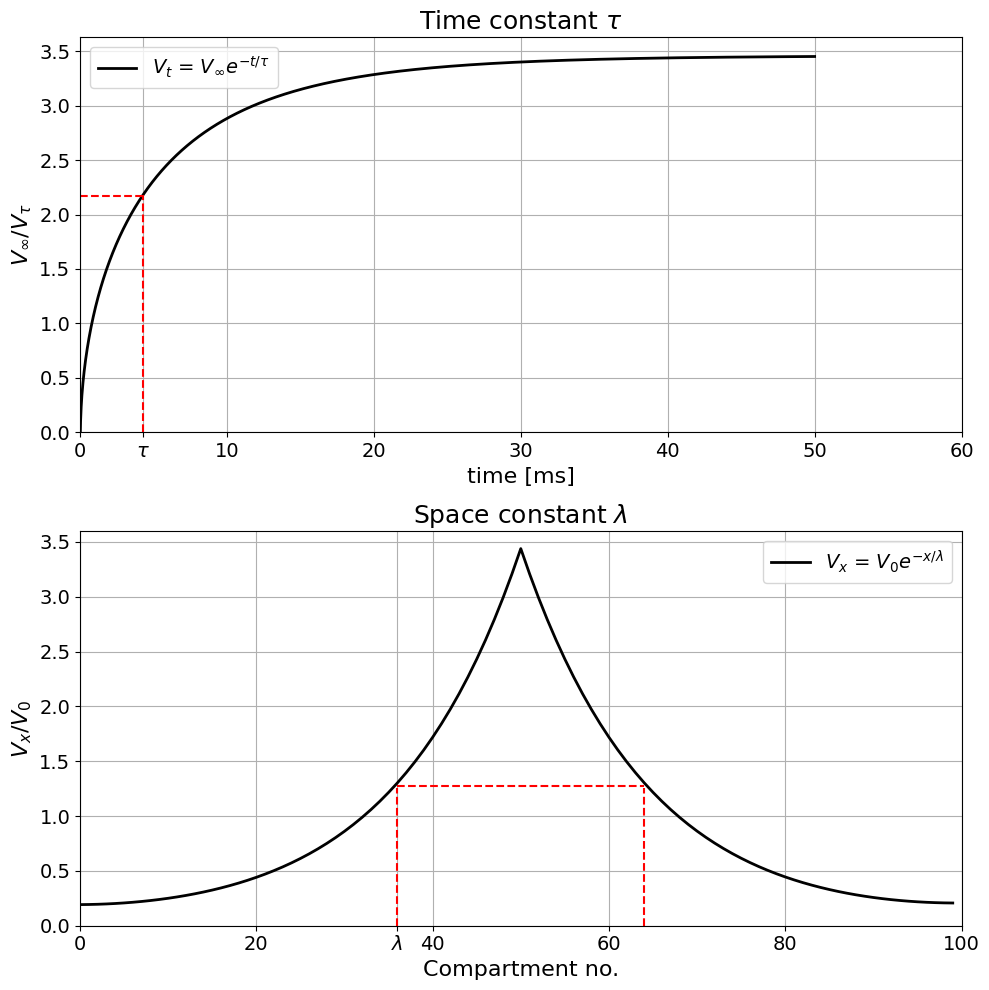

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize =(10,10))

# Plot 1
# Constant stimulation of compartment 50
ax1.plot(t, Vm[50, :], linewidth=2, color='black', label=r"$V_t$ = $V_\infty$$e^{-t/\tau}$")
ax1.set_xlabel('time [ms]', fontsize=16)
ax1.set_ylabel(r"$V_\infty$/$V_\tau$", fontsize=16)
ax1.set_title(r"Time constant $\tau$", fontsize=18)
ax1.set_xlim(xmin=0)
ax1.set_ylim(ymin=0)
ax1.tick_params(labelsize=14)
ax1.grid(True)

# Calculate the threshold value (63% of the maximum value)
threshold_value = 0.63 * np.max(Vm[50, :])

# Find the index where the membrane potential first exceeds the threshold
exceed_indices = np.where(Vm[50, :] > threshold_value)[0]
first_exceed_index = exceed_indices[0]
threshold_time = t[first_exceed_index]

# Plotting
ax1.axvline(x=t[first_exceed_index],  ymax = 0.6, color='red', linestyle='--')
ax1.axhline(y=threshold_value, xmax = 0.07, color='red', linestyle='--')
ax1.legend(fontsize=14)

# Get existing x-axis tick positions
existing_ticks = ax1.get_xticks()

# Add the threshold time as a special tick
special_ticks = list(existing_ticks) + [threshold_time]

# Set the new tick positions
ax1.set_xticks(special_ticks)

# Set labels for the special tick positions
tick_labels = [str(int(tick)) if tick != threshold_time else r"$\tau$" for tick in special_ticks]
ax1.set_xticklabels(tick_labels)


# Plot 2
# Exponential decay of Vm along the axon at steady state (t = 4000 ms)
ax2.plot(Vm[:, 3999], linewidth=2, color='black', label=r"$V_x$ = $V_0$$e^{-x/\lambda}$")
ax2.set_xlabel('Compartment no.', fontsize=16)
ax2.set_ylabel(r"$V_x$/$V_0$", fontsize=16)
ax2.set_title(r"Space constant $\lambda$", fontsize=18)
ax2.set_xlim(xmin=0)
ax2.set_xlim(xmax=100)
ax2.set_ylim(ymin=0)
ax2.tick_params(labelsize=14)
ax2.grid(True)

# Calculate the threshold value (63% of the maximum value)
threshold_value = 0.37 * np.max(Vm[50, :])

# Find the index where the membrane potential first exceeds the threshold
exceed_indices = np.where(Vm[50, :] > threshold_value)[0]
exceed_compartment = np.where(Vm[:, 3999] > threshold_value)[0]


# Plotting
ax2.axvline(x=exceed_compartment[0],  color='red', ymax = 0.35, linestyle='--')
ax2.axvline(x=exceed_compartment[-1], color='red', ymax = 0.35, linestyle='--')
ax2.axhline(y=threshold_value, color='red', xmin = 0.36, xmax = 0.64, linestyle='--')
ax2.legend(fontsize=14)

# Get existing x-axis tick positions
existing_ticks = ax2.get_xticks()

# Add the threshold time as a special tick
special_ticks = list(existing_ticks) + [exceed_compartment[0]] 

# Set the new tick positions
ax2.set_xticks(special_ticks)

# Set labels for the special tick positions
tick_labels = [str(int(tick)) if tick != exceed_compartment[0] else r"$\lambda$" for tick in special_ticks]
ax2.set_xticklabels(tick_labels)



plt.tight_layout()
plt.show()

## Active Cable Neuron Model

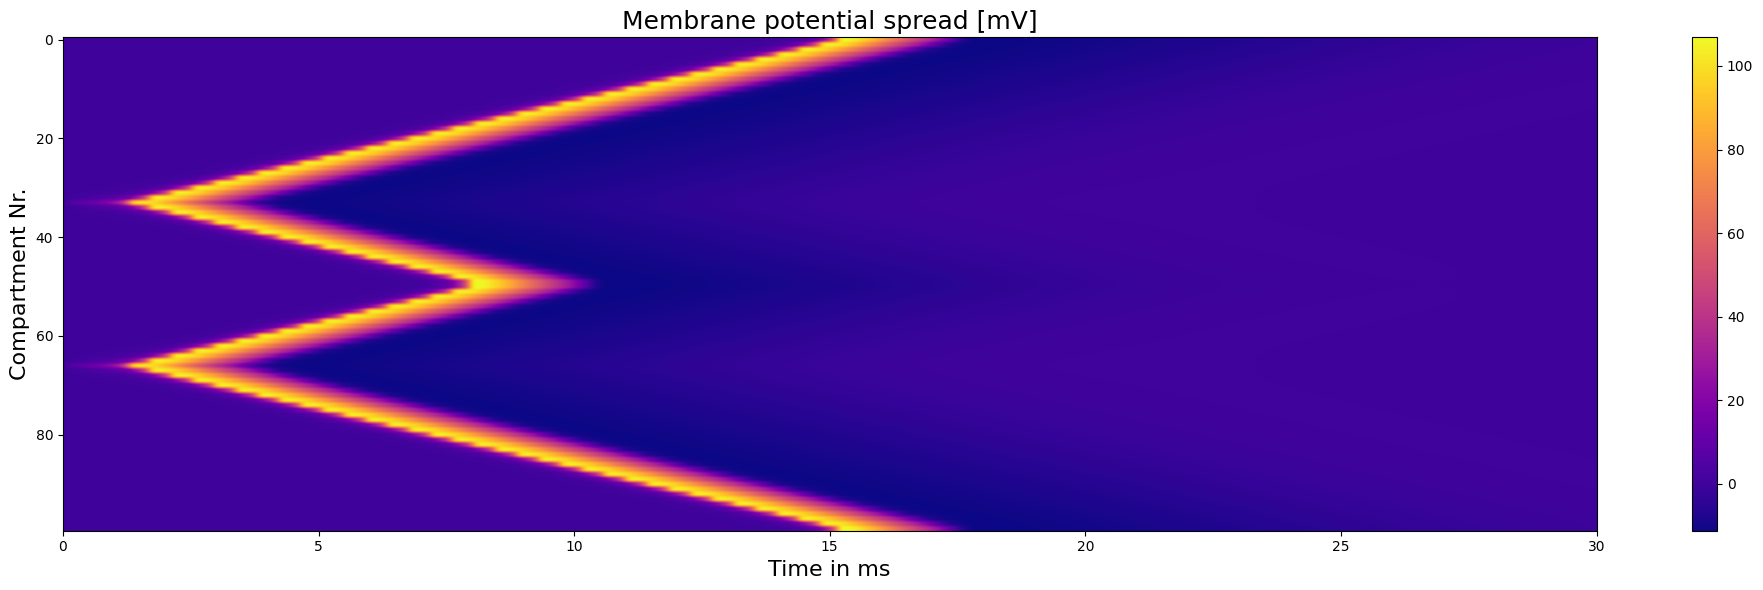

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class HHFormulas:
    def __init__(self):
        self.Vm = None
        self.dt = None
        self.k = None
        self.T = 6.3
        self.gK = 36
        self.eK = -12
        self.gNa = 120
        self.eNa = 115
        self.gL = 0.3
        self.eL = 10.6
        self.alpha_m = None
        self.alpha_n = None
        self.alpha_h = None
        self.beta_m = None
        self.beta_n = None
        self.beta_h = None
        self.tau_m = None
        self.tau_n = None
        self.tau_h = None
        self.p_m = None
        self.p_n = None
        self.p_h = None
        self.m = None
        self.n = None
        self.h = None
        self.iK = None
        self.iNa = None
        self.iL = None

    def calc_all(self):
        self.calculate_gates_and_time_constants()
        self.calculate_mnh()
        self.calculate_currents()

    def calculate_gates_and_time_constants(self):
        self.k_fcn()
        self.alpha_m_fcn()
        self.alpha_n_fcn()
        self.alpha_h_fcn()
        self.beta_m_fcn()
        self.beta_n_fcn()
        self.beta_h_fcn()
        self.tau_m_fcn()
        self.tau_n_fcn()
        self.tau_h_fcn()
        self.p_m_fcn()
        self.p_n_fcn()
        self.p_h_fcn()

    def calculate_mnh(self):
        if self.m is None:
            self.m = self.p_m
            self.n = self.p_n
            self.h = self.p_h
        else:
            self.m_fcn()
            self.n_fcn()
            self.h_fcn()

    def calculate_currents(self):
        self.ik_fcn()
        self.ina_fcn()
        self.il_fcn()

    def tau_m_fcn(self):
        self.tau_m = 1. / (self.alpha_m + self.beta_m)

    def tau_n_fcn(self):
        self.tau_n = 1. / (self.alpha_n + self.beta_n)

    def tau_h_fcn(self):
        self.tau_h = 1. / (self.alpha_h + self.beta_h)

    def p_m_fcn(self):
        self.p_m = self.alpha_m / (self.alpha_m + self.beta_m)

    def p_n_fcn(self):
        self.p_n = self.alpha_n / (self.alpha_n + self.beta_n)

    def p_h_fcn(self):
        self.p_h = self.alpha_h / (self.alpha_h + self.beta_h)

    def alpha_m_fcn(self):
        self.alpha_m = (2.5 - 0.1 * self.Vm) / (np.exp(2.5 - 0.1 * self.Vm) - 1)

    def beta_m_fcn(self):
        self.beta_m = 4 * np.exp(-self.Vm / 18)

    def alpha_n_fcn(self):
        self.alpha_n = (0.1 - 0.01 * self.Vm) / (np.exp(1 - 0.1 * self.Vm) - 1)

    def beta_n_fcn(self):
        self.beta_n = 0.125 * np.exp(-self.Vm / 80)

    def alpha_h_fcn(self):
        self.alpha_h = 0.07 * np.exp(-self.Vm / 20)

    def beta_h_fcn(self):
        self.beta_h = 1 / (np.exp((3 - 0.1 * self.Vm)) + 1)

    def m_fcn(self):
        self.m = self.m + self.dt * self.k * (self.alpha_m * (1 - self.m) - self.beta_m * self.m)

    def n_fcn(self):
        self.n = self.n + self.dt * self.k * (self.alpha_n * (1 - self.n) - self.beta_n * self.n)

    def h_fcn(self):
        self.h = self.h + self.dt * self.k * (self.alpha_h * (1 - self.h) - self.beta_h * self.h)

    def k_fcn(self):
        self.k = 3 ** (0.1 * (self.T - 6.3))

    def ik_fcn(self):
        self.iK = self.gK * self.n ** 4 * (self.Vm - self.eK)

    def ina_fcn(self):
        self.iNa = self.gNa * self.m ** 3 * self.h * (self.Vm - self.eNa)

    def il_fcn(self):
        self.iL = self.gL * (self.Vm - self.eL)


# Create an instance of the HHFormulas class
hh = HHFormulas()

# Define some parameters
hh.dt = 0.01
hh.Vm = 0

# Calculate all
hh.calc_all()

# Define parameters
g_Na = 120e-3  # conductance Sodium [ms/cm2]
g_K = 39e-3    # conductance Potassium [ms/cm2]
g_L = 0.3e-3   # conductance leak [ms/cm2]

v_Na = 115e-3   # voltage Sodium [mV]
v_K = -12e-3    # voltage Potassium [mV]
v_L = 10.6e-3   # voltage leak [mV]
v_Rest = -70e-3  # resting potential [mV]

cm = 1e-6        # membrane capacity [uF/cm2]

p_Axon = 0.1e3   # density axon [kOhm*cm]
r_Axon = 2e-4    # radius axon [cm]
L_comp = 0.1e-4  # length compartment [cm]


# time
dt = 0.01
t = np.arange(dt, 50 + dt, dt)

# compartments
n = 100

# membrane
Cm = 1
Rm = 10

# membrane voltage
Vm = np.zeros((n, len(t)))

# axon
p = 0.1        # conductance for the axon
L = 1e-6       # length for 1 compartment
r = 2e-4       # radius for the axon

# main script formula 2.43
Ra = (p * L) / (np.pi * r ** 2)  # resistance of the axon

# connectivity matrix
c = np.ones((n, 1)) * -2
c[0] = -1
c[-1] = -1

C = np.diag(c[:, 0], 0)
C = C + np.diag(np.ones(n - 1), 1)
C = C + np.diag(np.ones(n - 1), -1)

# part A from exercise_5_slides page 7/9
A = np.eye(n) - (dt / (Cm * Ra)) * C

# stimulus current
Istim = np.zeros((n, len(t)))

# Higher stimulation = more APs
Istim[n // 3, :100] = 30
Istim[n // 3 * 2, :100] = 30

for idx in range(len(t) - 1):
    # calculate all values from class hh_formula
    hh.calc_all()

    # calculate membrane current
    Im = hh.iNa + hh.iK + hh.iL

    # part b from exercise_5_slides page 7/9
    b = Vm[:, idx] + dt / (Cm * Ra) * (-Im + Istim[:, idx])

    # "x"
    Vm[:, idx + 1] = solve(A, b)
    hh.Vm = Vm[:, idx + 1]

# main script figure 2.11 top+botton
fig, ax = plt.subplots(figsize=(20, 6))

# Color scaled image of compartments
im = ax.imshow(Vm, aspect='auto', cmap='plasma')
fig.colorbar(im, ax=ax)


ax.set_title('Membrane potential spread [mV]', fontsize=18)
ax.set_xlabel('Time in ms', fontsize=16)
ax.set_ylabel('Compartment Nr.', fontsize=16)
ax.set_xticks(np.arange(0, len(t), len(t) // 10))
ax.set_xticklabels(np.arange(0, 50, 5))
ax.set_xlim(0, 3000)

plt.tight_layout()
plt.show()


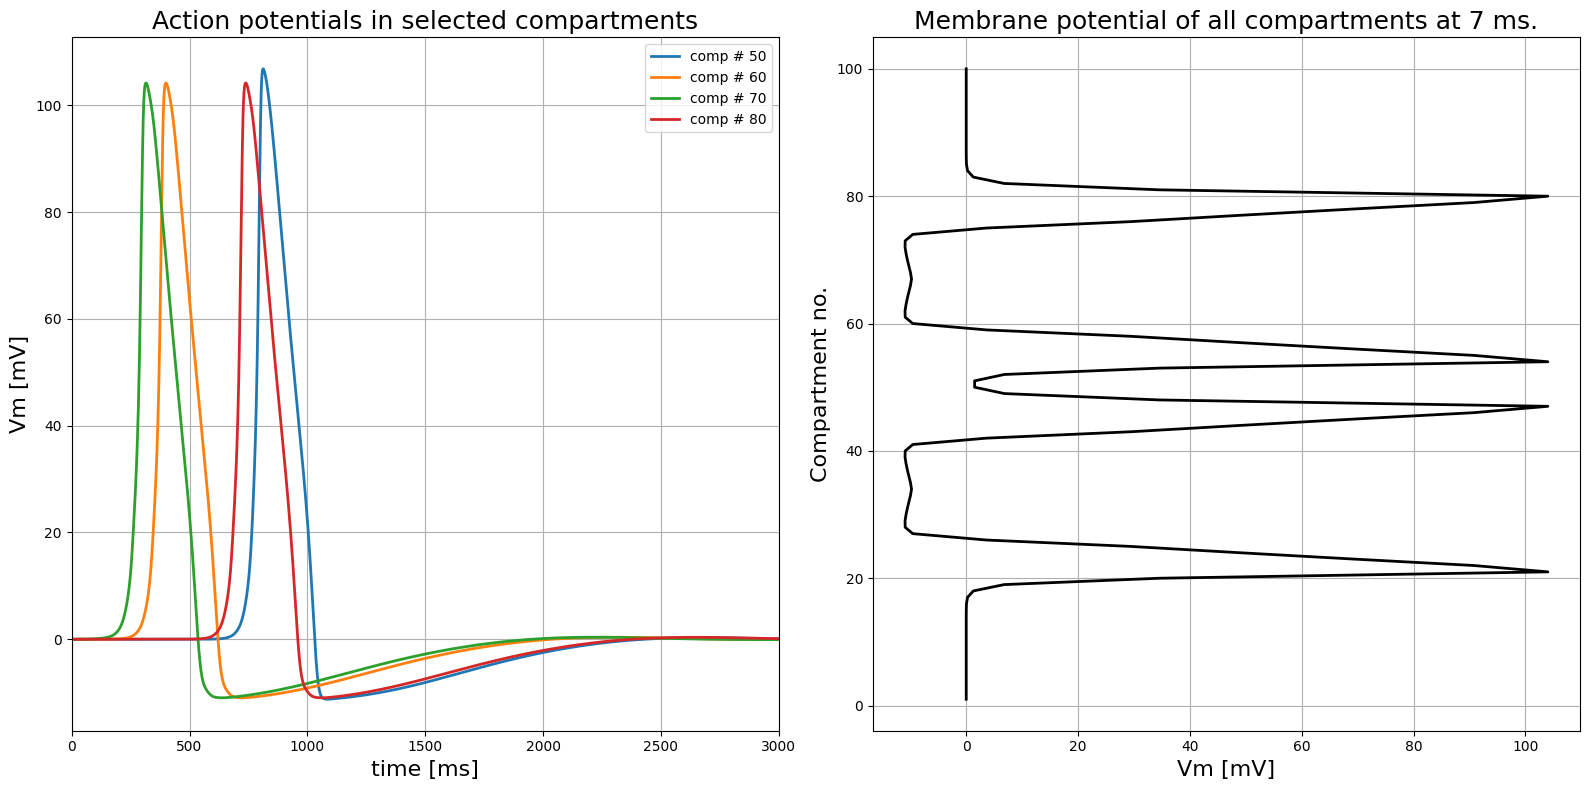

In [19]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
compartments_to_plot = [50, 60, 70, 80]
for comp in compartments_to_plot:
    plt.plot(Vm[comp, :], linewidth=2, label=f'comp # {comp}')
plt.legend()
plt.xlabel('time [ms]', fontsize=16)
plt.ylabel('Vm [mV]', fontsize=16)
plt.title('Action potentials in selected compartments', fontsize=18)
plt.grid(True)
plt.xlim(0, 3000)

plt.subplot(1, 2, 2)
plt.plot(Vm[:, 700], np.arange(1, 101), linewidth=2, color='black')
plt.xlabel('Vm [mV]', fontsize=16)
plt.ylabel('Compartment no.', fontsize=16)
plt.title('Membrane potential of all compartments at 7 ms.', fontsize=18)
plt.grid(True)

plt.tight_layout()
plt.show()